<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944210 entries, 0 to 1944209
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

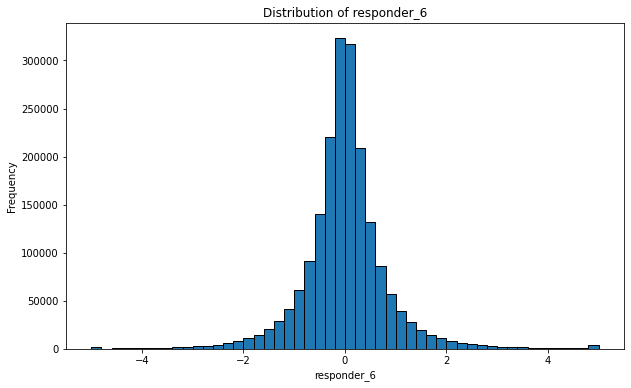

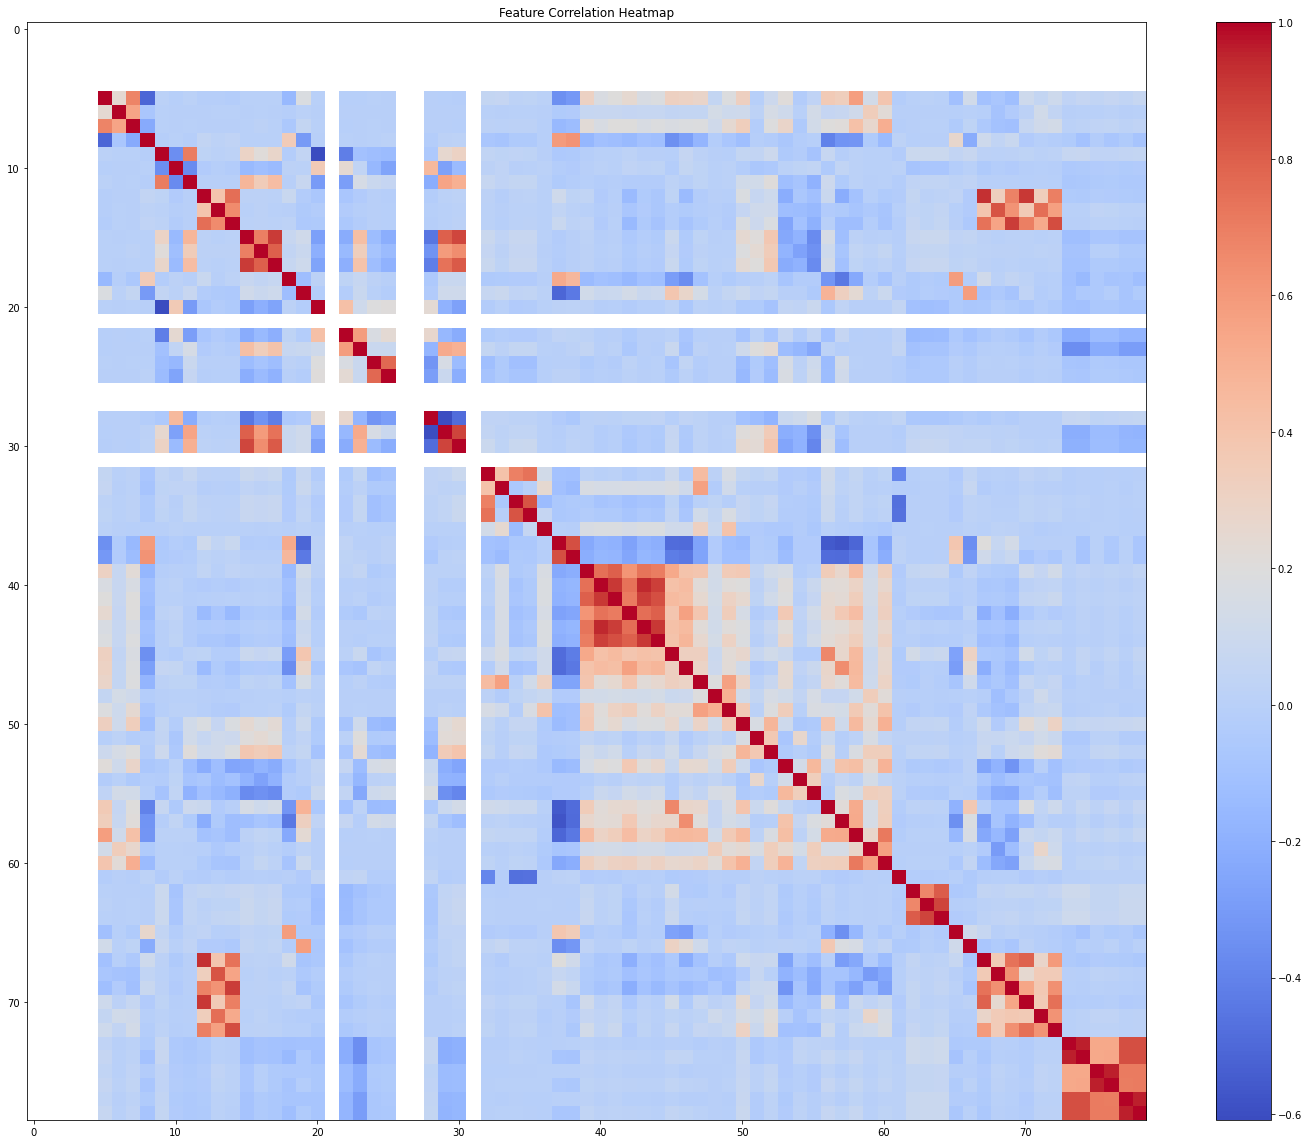

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_parquet(r'jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet')
lags_df = pd.read_parquet(r'jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')

# Basic data exploration
print(train_df.info())
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())

# Plot distribution of responder_6
plt.figure(figsize=(10, 6))
plt.hist(train_df['responder_6'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of responder_6')
plt.xlabel('responder_6')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap of features
feature_cols = [col for col in train_df.columns if col.startswith('feature_')]
correlation_matrix = train_df[feature_cols].corr()
plt.figure(figsize=(20, 16))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [5]:
# Basic statistics of features
print(train_df[feature_cols].describe())
# Check for constant or near-constant features
constant_features = [col for col in feature_cols if train_df[col].nunique() <= 1]
print("Constant features:", constant_features)
# Check for highly correlated features
high_corr_features = set()
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            high_corr_features.add(feature_cols[i])
            high_corr_features.add(feature_cols[j])
print("Highly correlated features:", high_corr_features)

       feature_00  feature_01  feature_02  feature_03  feature_04  \
count         0.0         0.0         0.0         0.0         0.0   
mean          NaN         NaN         NaN         NaN         NaN   
std           NaN         NaN         NaN         NaN         NaN   
min           NaN         NaN         NaN         NaN         NaN   
25%           NaN         NaN         NaN         NaN         NaN   
50%           NaN         NaN         NaN         NaN         NaN   
75%           NaN         NaN         NaN         NaN         NaN   
max           NaN         NaN         NaN         NaN         NaN   

         feature_05    feature_06    feature_07    feature_08    feature_09  \
count  1.944210e+06  1.944210e+06  1.944210e+06  1.927230e+06  1.944210e+06   
mean  -4.463175e-02 -6.456066e-03 -1.984165e-02  5.979728e-02  2.862838e+01   
std    9.471079e-01  9.340423e-01  9.664304e-01  9.221880e-01  2.391003e+01   
min   -1.176608e+01 -2.514354e+01 -2.032179e+01 -6.224619e+00 

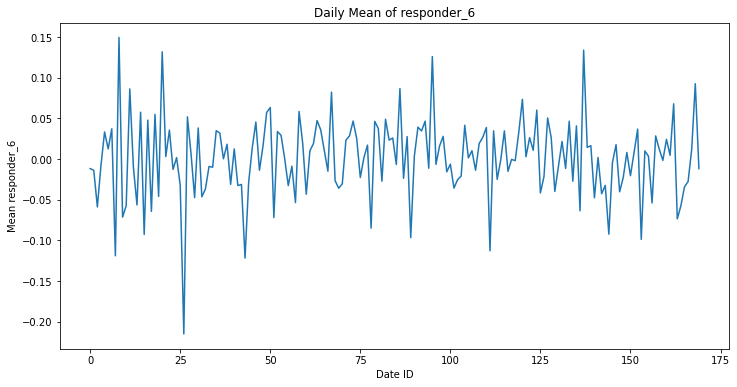

In [6]:
# Group by date_id and calculate mean of responder_6
daily_mean = train_df.groupby('date_id')['responder_6'].mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean.values)
plt.title('Daily Mean of responder_6')
plt.xlabel('Date ID')
plt.ylabel('Mean responder_6')
plt.show()

Number of unique symbols: 20


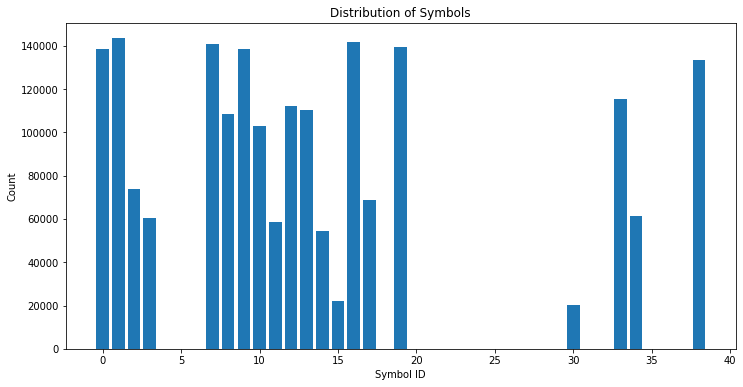

In [7]:
# Count of unique symbols
print("Number of unique symbols:", train_df['symbol_id'].nunique())
# Distribution of symbols
symbol_counts = train_df['symbol_id'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(symbol_counts.index, symbol_counts.values)
plt.title('Distribution of Symbols')
plt.xlabel('Symbol ID')
plt.ylabel('Count')
plt.show()

In [8]:
# Remove constant and missing features
constant_features = ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']
train_df = train_df.drop(columns=constant_features)
# Handle highly correlated features (you might want to keep one from each correlated group)
correlated_features = ['feature_73', 'feature_74', 'feature_75', 'feature_76', 'feature_77', 'feature_78']
train_df = train_df.drop(columns=correlated_features[1:])  # Keep the first one, drop the rest
# Create time-based features
train_df['day_of_week'] = train_df['date_id'] % 7
train_df['time_of_day'] = train_df['time_id'] % 24
# Create lag features for responder_6
train_df['responder_6_lag1'] = train_df.groupby('symbol_id')['responder_6'].shift(1)
train_df['responder_6_lag2'] = train_df.groupby('symbol_id')['responder_6'].shift(2)
# Drop rows with NaN values created by lag features
train_df = train_df.dropna()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Select features and target
features = [col for col in train_df.columns if col.startswith('feature_') or col in ['weight', 'day_of_week', 'time_of_day', 'responder_6_lag1', 'responder_6_lag2']]
X = train_df[features]
y = train_df['responder_6']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
# Make predictions and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance.head(10))

In [ ]:
import matplotlib.pyplot as plt
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:1000], y_pred[:1000], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted responder_6')
plt.show()
# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance[:20].plot(x='feature', y='importance', kind='bar')
plt.title('Top 20 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()